In [3]:
cd ..

/Users/ulfaslak/Dropbox/MSc/sem12/MScProject/Academic/code/pipeline_code


In [615]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from py_pcha.PCHA import PCHA
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from collections import Counter
import os, sys
import re
import ast

FIGPATH = "../../master_thesis/figures/"
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE

## 0. Find archetypes in each dataset

### Facebook

In [611]:
DATADIR = "analysis/data/facebook/"
data_files = os.listdir(DATADIR)

Y0 = np.empty((0, 5))
for count, data_file in enumerate(data_files):
    print count,
    with open(DATADIR + data_file, 'r') as infile:
        dat = ast.literal_eval(
            infile
            .read()
            .replace("{", "[").replace("}", "]")
        )
        Y0 = np.vstack([Y0, (np.array([d[1] for d in dat])-3)/2.0])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30


## SAPA

In [699]:
# Load the raw data
dat1 = pd.read_csv("analysis/data/SAPA/SAPAdata18aug2010thru06apr2015.csv")

In [724]:
# Keys relating questions to traits
keys1 = pd.read_csv("analysis/data/SAPA/superKey756.csv", index_col=0)

In [756]:
# Keys for different inventories
keysSPI_5 = keys1[['SPI_5intelOpen', 'SPI_5conscientious', 'SPI_5extraversion', 'SPI_5compHonHum', 'SPI_5neuroticism']]
keysSPI_5 = keysSPI_5[keysSPI_5.any(1)]

keysIPIP100 = keys1[['IPIP100intel', 'IPIP100consc', 'IPIP100extra', 'IPIP100agree', 'IPIP100stability']]
keysIPIP100 = keysIPIP100[keysIPIP100.any(1)]

keysIPIP50 = keys1[['IPIP50Intel', 'IPIP50Consc', 'IPIP50Extra', 'IPIP50Agree', 'IPIP50EmoSt']]
keysIPIP50 = keysIPIP50[keysIPIP50.any(1)]

keysNEO = keys1[['NEO_O', 'NEO_C', 'NEO_E', 'NEO_A', 'NEO_N']]
keysNEO = keysNEO[keysNEO.any(1)]

keysNEO1 = keys1[['NEOo1', 'NEOc1', 'NEOe1', 'NEOa1', 'NEOn1']]
keysNEO1 = keysNEO1[keysNEO1.any(1)]

keysNEO2 = keys1[['NEOo2', 'NEOc2', 'NEOe2', 'NEOa2', 'NEOn2']]
keysNEO2 = keysNEO2[keysNEO2.any(1)]

keysNEO3 = keys1[['NEOo3', 'NEOc3', 'NEOe3', 'NEOa3', 'NEOn3']]
keysNEO3 = keysNEO3[keysNEO3.any(1)]

keysNEO4 = keys1[['NEOo4', 'NEOc4', 'NEOe4', 'NEOa4', 'NEOn4']]
keysNEO4 = keysNEO4[keysNEO4.any(1)]

keysNEO5 = keys1[['NEOo5', 'NEOc5', 'NEOe5', 'NEOa5', 'NEOn5']]
keysNEO5 = keysNEO5[keysNEO5.any(1)]

keysNEO6 = keys1[['NEOo6', 'NEOc6', 'NEOe6', 'NEOa6', 'NEOn6']]
keysNEO6 = keysNEO6[keysNEO6.any(1)]

keys1_all = [keysSPI_5, keysIPIP100, keysIPIP50, keysNEO, keysNEO1, keysNEO2, keysNEO3, keysNEO4, keysNEO5, keysNEO6]
keys1_all_labels = ["keysSPI_5", "keysIPIP100", "keysIPIP50", "keysNEO", "keysNEO1", "keysNEO2", "keysNEO3", "keysNEO4", "keysNEO5", "keysNEO6"]

In [765]:
# Compute question overlap between inventories to indentify main ones
overlap = np.empty((len(keys1_all), len(keys1_all)))
for i, k_i in enumerate(keys1_all):
    for j, k_j in enumerate(keys1_all):
        overlap[i, j] = int(len(set(k_i.index) & set(k_j.index)))

In [768]:
print "Number of questions from each inventory that are used in other inventories"
pd.DataFrame(overlap, index=keys1_all_labels, columns=keys1_all_labels)

Number of questions from each inventory that are used in other inventories


,keysSPI_5,keysIPIP100,keysIPIP50,keysNEO,keysNEO1,keysNEO2,keysNEO3,keysNEO4,keysNEO5,keysNEO6
keysSPI_5,75,29,18,37,5,9,7,0,11,5
keysIPIP100,29,99,50,54,14,13,12,2,10,3
keysIPIP50,18,50,50,28,8,6,7,1,5,1
keysNEO,37,54,28,300,50,50,50,50,50,50
keysNEO1,5,14,8,50,50,0,0,0,0,0
keysNEO2,9,13,6,50,0,50,0,0,0,0
keysNEO3,7,12,7,50,0,0,50,0,0,0
keysNEO4,0,2,1,50,0,0,0,50,0,0
keysNEO5,11,10,5,50,0,0,0,0,50,0
keysNEO6,5,3,1,50,0,0,0,0,0,50


In [875]:
# Result: IPIP50 is contained in IPIP99, and that NEO(1-6) is contained
# in NEO. SPI, IPIP100 and NEO share some questions but not all. 
# 
# Going forward IPIP100 is used.

In [776]:
# Raw data for only IPIP100 inventory
dat1IPIP100 = dat1[keysIPIP100.index]

In [863]:
traits = ['O', 'C', 'E', 'A', 'N']

trait_questions = {} # {'A': {'q_1162': 1, ...}, 'C': {'q_1374': ...}, ... }
for i, c in enumerate(keysIPIP100.columns):
    if c == "N": multiplier = -1
    else: multiplier = 1
    # Notice the multiplier! Reverses stability to neuroticism
    trait_questions[traits[i]] = dict((k, multiplier*v) for (k, v) in zip(keysIPIP100[c].index, keysIPIP100[c].values) if v != 0)

def compute_BF_scores(vec):
    # Take a row from the raw data and return a nice BF vector
    vec_dict = dict(zip(vec.index, vec.values))
    t_vec = []
    for t in traits:
        questions = trait_questions[t]
        trait = [vec_dict[q] if v > 0 else 7-vec_dict[q] for q, v in questions.items() if not np.isnan(vec_dict[q])]
        if len(trait) < 5:
            return False
        t_vec.append(np.mean(trait))
    return t_vec

Y1 = np.empty((0, 5))
for u in dat1IPIP100.index:
    # Iterate through rows of raw IPIP100 data and compute score vectors
    y1 = compute_BF_scores(dat1IPIP100.loc[u])
    if y1: # y1 is False if too few aswers
        Y1 = np.vstack([Y1, np.array(y1)])

In [979]:
Y1 = (Y1-3.5)/2.5

### MIDUS3

In [260]:
# Load data

# Y2
dat2 = pd.read_csv("analysis/data/MIDUS/MIDUS3.tsv", delimiter="\t")
Y2 = np.array(dat2[["C1SOPEN", "C1SCONS1", "C1SEXTRA", "C1SAGREE", "C1SNEURO"]])
Y2 = Y2[~(~(Y2.reshape((-1, 1)) <= 4).reshape((-1, 5))).any(1)]
Y2 = Y2[~(~(Y2.reshape((-1, 1)) >= 1).reshape((-1, 5))).any(1)]
Y2 = (Y2-2.5)/1.5

## Sensible DTU

In [ ]:
# Y3
Y3 = np.loadtxt("../../data/Y.csv", delimiter=",")
Y3 = (Y3-3)/2.0

## Summary statistics

In [981]:
Ys = [Y0, Y1, Y2, Y3]
Ys_labels = ["Facebook   ", "SAPA       ", "MIDUS3     ", "SensibleDTU"]
for i, Y in enumerate(Ys):
    print Ys_labels[i], Y.shape

Facebook    (2665006, 5)
SAPA        (75689, 5)
MIDUS3      (2715, 5)
SensibleDTU (734, 5)


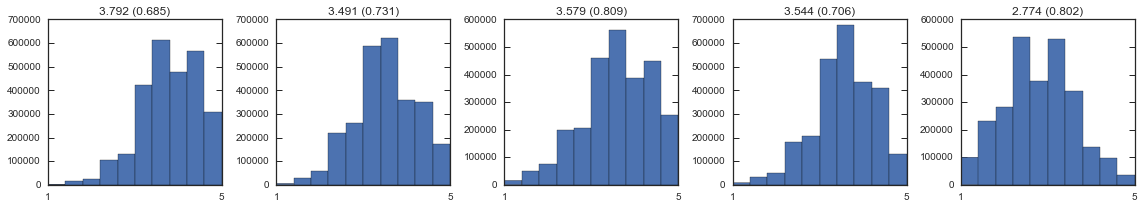

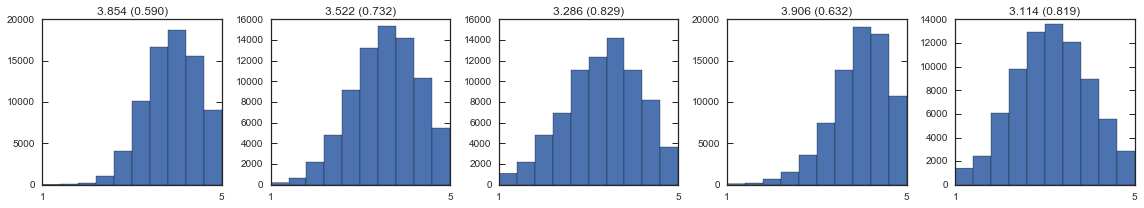

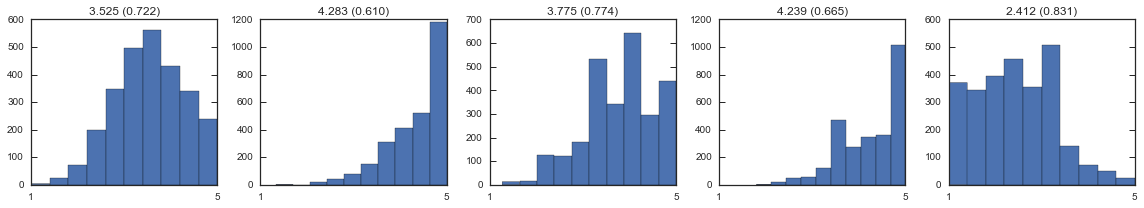

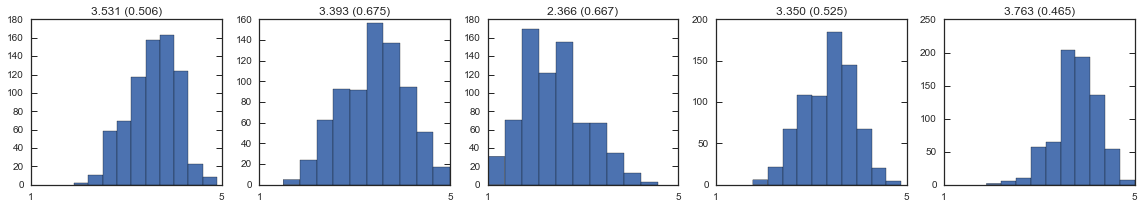

In [990]:
for i, Y in enumerate(Ys):
    plt.figure(None, (16, 3))
    for j in range(5):
        plt.subplot(1, 5, j+1)
        plt.title("%.03f (%.03f)" % (np.mean(Y[:, j]*2+3), np.std(Y[:, j]*2+3)))
        plt.hist(Y[:, j]*2+3)
        plt.xticks([1, 5])
    plt.tight_layout()
    plt.show()
    

# Compute archetypes

### Test if PCHA parameter $\delta$ is scaling independent

In [953]:
A3   = PCHA(Y3.T    , 6, delta=0.5)[0].T
A3_s = PCHA(Y3.T*100, 6, delta=0.5)[0].T/100

# reorder rows
A3_s = A3_s[reorder_to(A3_s, A3)]

In [962]:
(A3 - A3_s) > 0.001

matrix([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]], dtype=bool)

    Result: Archetypes are the same independent of scaling

In [669]:
def get_subset(X, size):
    return X[np.random.choice(range(X.shape[0]), size)]
def get_archetypes(X):
    while True:
        try:
            return PCHA(X.T, 6, delta=0.2)[0].T
        except Exception as e:
            #print e
            pass

In [693]:
K = 1000

A_long = np.empty((0, 5))
for k in range(K):
    A_k = get_archetypes(get_subset(Y2, K)).A
    A_long = np.vstack([A_long, A_k])

In [694]:
y = KMeans(n_clusters=6).fit_predict(A_long)

In [933]:
A_kmeans_median = np.empty((6, 5))
A_kmeans_mean = np.empty((6, 5))
A_kmeans_var = np.empty((6, 5))
A_kmeans_std = np.empty((6, 5))
for i in range(6):
    A_kmeans_median[i, :] = np.median(A_long[y==i], axis=0)
    A_kmeans_mean[i, :] = np.mean(A_long[y==i], axis=0)
    A_kmeans_var[i, :] = np.var(A_long[y==i], axis=0)
    A_kmeans_std[i, :] = np.std(A_long[y==i], axis=0)

In [939]:
order1 = reorder_to(A_kmeans_median, (arc2-3)/2)
print order
order2 = reorder_to(A_kmeans_mean, (arc2-3)/2)
print order

[4, 2, 0, 5, 1, 3]
[4, 2, 0, 5, 1, 3]


[[ 1.13  1.01  1.06  1.04 -1.18]
 [-0.38 -0.67 -0.24 -0.14  0.  ]
 [ 0.79  0.73  1.02  1.11  0.8 ]
 [ 0.08  0.97 -0.46 -0.18 -0.8 ]
 [-0.46  0.65 -0.56  0.2   0.66]
 [-0.52  0.76  0.88  1.18 -0.81]]

[[ 0.08  0.97 -0.46 -0.18 -0.8 ]
 [ 0.79  0.73  1.02  1.11  0.8 ]
 [ 1.13  1.01  1.06  1.04 -1.18]
 [-0.52  0.76  0.88  1.18 -0.81]
 [-0.38 -0.67 -0.24 -0.14  0.  ]
 [-0.46  0.65 -0.56  0.2   0.66]]

[[-0.46  0.65 -0.56  0.2   0.66]
 [ 0.79  0.73  1.02  1.11  0.8 ]
 [ 1.13  1.01  1.06  1.04 -1.18]
 [-0.52  0.76  0.88  1.18 -0.81]
 [-0.38 -0.67 -0.24 -0.14  0.  ]
 [ 0.08  0.97 -0.46 -0.18 -0.8 ]]



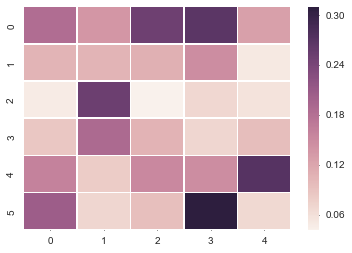

In [941]:
print A_kmeans_median
print 
print A_kmeans_median[order1]
print
print A_kmeans_median[order2]
print
sns.heatmap(A_kmeans_var[order])

In [904]:
X

array([[ 0.08,  0.97, -0.46, -0.18, -0.8 ],
       [ 0.79,  0.73,  1.02,  1.11,  0.8 ],
       [ 1.13,  1.01,  1.06,  1.04, -1.18],
       [-0.52,  0.76,  0.88,  1.18, -0.81],
       [-0.38, -0.67, -0.24, -0.14,  0.  ],
       [-0.46,  0.65, -0.56,  0.2 ,  0.66]])

In [935]:
def reorder_to(A_k, tilde_A):

    distance_matrix = np.ones((6, 6))*np.inf
    for i, A_i_k in enumerate(A_k):
        for ii, tilde_A_i in enumerate(tilde_A):
            distance_matrix[i, ii] = euclidean(A_i_k, tilde_A_i)
            
    reorder = [[] for _ in range(6)]
    #A_k_sorted = np.empty((6, 5))
    for _ in range(6):
        ind = np.argmin(distance_matrix)
        i, ii = ind/6, ind%6
        #A_k_sorted[ii, :] = A_k[i, :]
        reorder[ii] = i

        #print ii, i, distance_matrix[i, ii]
        distance_matrix[i, :] = np.inf
        distance_matrix[:, ii] = np.inf
    
    #return A_k_sorted, reorder
    return reorder

In [692]:
K = 1000

A = np.dstack([np.empty((6, 5, 0)), (arc2-3)/2])
for k in range(K):
    A_k = get_archetypes(get_subset(Y2, K)).A
    
    # Reorder rows to match convention order
    A_k = A_k[reorder_to(A_k, np.median(A, axis=2))]
        
    if k == 0:
        # Remove ordering reference
        A = A[:, :, 1:]
        
    A = np.dstack([A, A_k])

In [884]:
np.var(A, axis=2)

array([[ 0.2 ,  0.1 ,  0.11,  0.19,  0.13],
       [ 0.08,  0.07,  0.12,  0.05,  0.04],
       [ 0.05,  0.03,  0.03,  0.03,  0.01],
       [ 0.37,  0.25,  0.54,  0.28,  0.35],
       [ 0.24,  0.21,  0.36,  0.17,  0.2 ],
       [ 0.22,  0.22,  0.22,  0.16,  0.32]])

In [883]:
np.median(A, axis=2)-np.mean(A, axis=2)

array([[ 0.01,  0.07, -0.05, -0.15, -0.06],
       [ 0.02, -0.  ,  0.11,  0.09, -0.  ],
       [ 0.1 ,  0.03,  0.05,  0.05, -0.06],
       [-0.08,  0.06, -0.27,  0.1 ,  0.18],
       [-0.07,  0.13,  0.29,  0.18, -0.14],
       [-0.02, -0.09,  0.05, -0.03, -0.08]])

In [536]:
17%5

2

## 1. Find the consensus archetypes

In [166]:
def scale(X):
    return (X-3)/2

In [167]:
dat = scale(np.array(pd.read_csv("build_dataset/data/archetypes.csv")))

# Load archetypes
arc0 = dat[:, range(0, 5)]
arc1 = dat[:, range(5, 10)]
arc2 = dat[:, range(10, 15)]
arc3 = dat[:, range(15, 20)]

arcs = [arc0, arc1, arc2, arc3]

In [254]:
A = np.empty((6, 5, 4))
for i, d in enumerate(arcs):
    A[:, :, i] = d
    
W = np.var(A, axis=2)
M = np.median(A, axis=2)

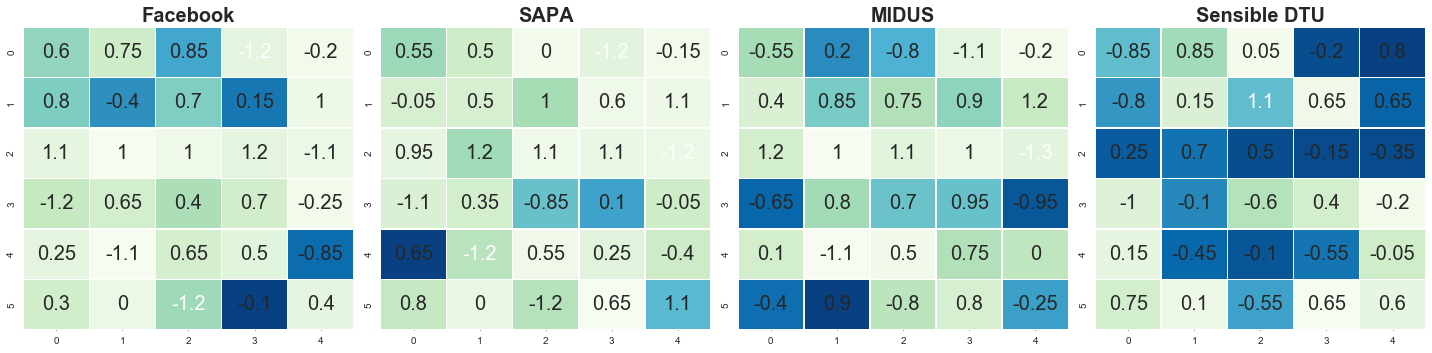

In [242]:
titles = ['Facebook', 'SAPA', 'MIDUS', 'Sensible DTU']

plt.figure(None, (20,5))
for i, d in enumerate(arcs):
    plt.subplot(1, 4, i+1)
    plt.title(titles[i], fontsize=20, fontweight="bold")
    if i != 3:
        sns.heatmap((abs(M-d))/W, cmap="GnBu", cbar=False, annot=False)
    else:
        sns.heatmap((abs(M-d))/W, cmap="GnBu", cbar=False)
    sns.heatmap(d, cbar=False, alpha=0, annot=True, annot_kws={"size": 20}, cmap="spring")
plt.tight_layout()
#plt.savefig(FIGPATH + "medianDistances2.pdf") # Never run this!
#plt.show()

In [259]:
A = np.empty((6, 5, 4))
for i, d in enumerate(arcs):
    A[:, :, i] = d
    
W = np.var(A[:, :, :-1], axis=2)
W_std = np.std(A[:, :, :-1], axis=2)
M = np.mean(A[:, :, :-1], axis=2)
M_meadian = np.median(A[:, :, :-1], axis=2)

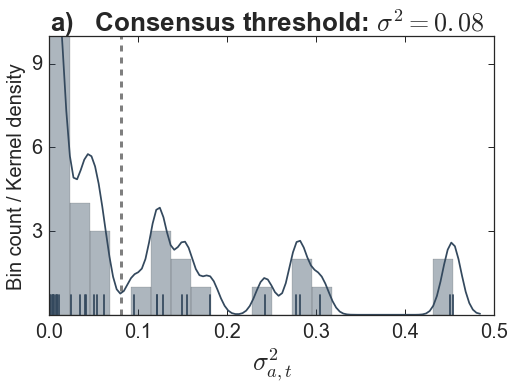

In [248]:
x = W.reshape((1, -1))[0]
c = "#34495e"

plt.figure(figsize=(7.3,5.5))
#plt.hist(x, 20, color="gray")
sns.kdeplot(x, bw=.01, color=c)
sns.distplot(x, bins=20, kde=False, rug=True, color=c)
plt.plot([0.08, 0.08], [0, 10], c="black", lw=3, alpha=0.5, ls="--")
plt.xlim([0, 0.5])
plt.ylim([0, 10])
plt.xticks(fontsize=20)
plt.yticks([3, 6, 9], fontsize=20)
plt.title("a)   Consensus threshold: $\sigma^2=0.08$  ", fontsize=26, fontweight="bold")
plt.xlabel("$\sigma_{a,t}^2$", fontsize=26)
plt.ylabel("Bin count / Kernel density", fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig(FIGPATH + "varianceThreshold.pdf")

## 2. Understand how DTU students are distributed in terms of CAs

In [6]:
cd ..

/Users/ulfaslak/Dropbox/MSc/sem12/MScProject/Academic/code/pipeline_code


In [169]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from py_pcha.PCHA import PCHA

from build_dataset.analysis.compute_thetas import compute_thetas

FIGPATH = "../../master_thesis/figures/"
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE

In [221]:
# Load data

# Y2
dat2 = pd.read_csv("analysis/data/MIDUS3.tsv", delimiter="\t")
Y2 = np.array(dat2[["C1SOPEN", "C1SCONS1", "C1SEXTRA", "C1SAGREE", "C1SNEURO"]])
Y2 = Y2[~(~(Y2.reshape((-1, 1)) <= 4).reshape((-1, 5))).any(1)]
Y2 = Y2[~(~(Y2.reshape((-1, 1)) >= 1).reshape((-1, 5))).any(1)]
Y2 = (Y2-2.5)/1.5

# Y3
Y3 = np.loadtxt("../../data/Y.csv", delimiter=",")
Y3 = (Y3-3)/2.0

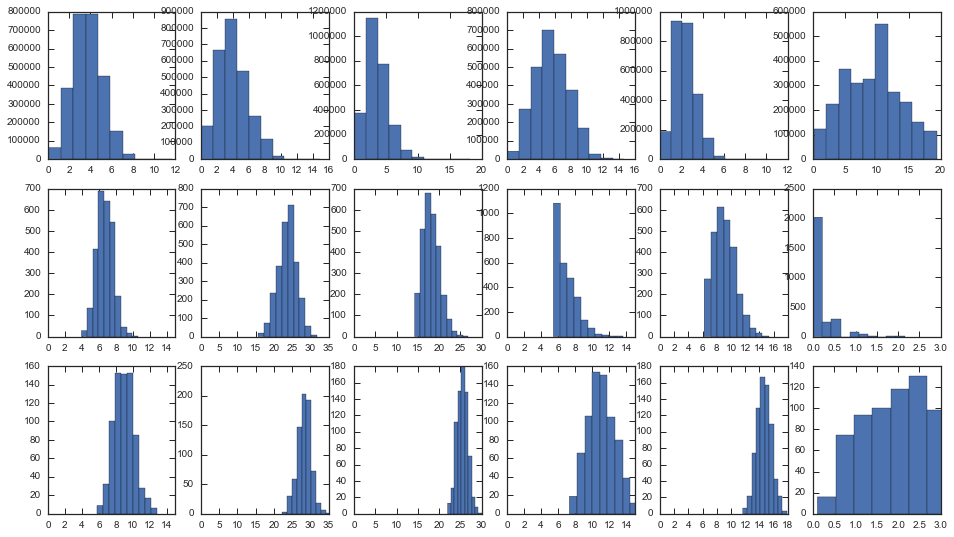

In [627]:
# COMPARE DISTANCE TO CA FOR ALL 3 DATASETS AND SEN DTU! Sampled points are shit.
#D0 = compute_thetas(Y0, penalty="consensus", return_D=True)
#D2 = compute_thetas(Y2, penalty="consensus", return_D=True)
#D3 = compute_thetas(Y3, penalty="consensus", return_D=True)

xranges = [[0, 15], [0, 35], [0, 30], [0, 15], [0, 18], [0, 3]]
plt.figure(None, (16,9))
for i in range(D0.shape[1]):
    plt.subplot(3, 6, i+1)
    plt.hist(D0[:, i])
    #plt.xlim(xranges[i])
for i in range(D2.shape[1]):
    plt.subplot(3, 6, i+7)
    plt.hist(D2[:, i])
    plt.xlim(xranges[i])
for i in range(D3.shape[1]):
    plt.subplot(3, 6, i+13)
    plt.hist(D3[:, i])
    plt.xlim(xranges[i])
plt.show()

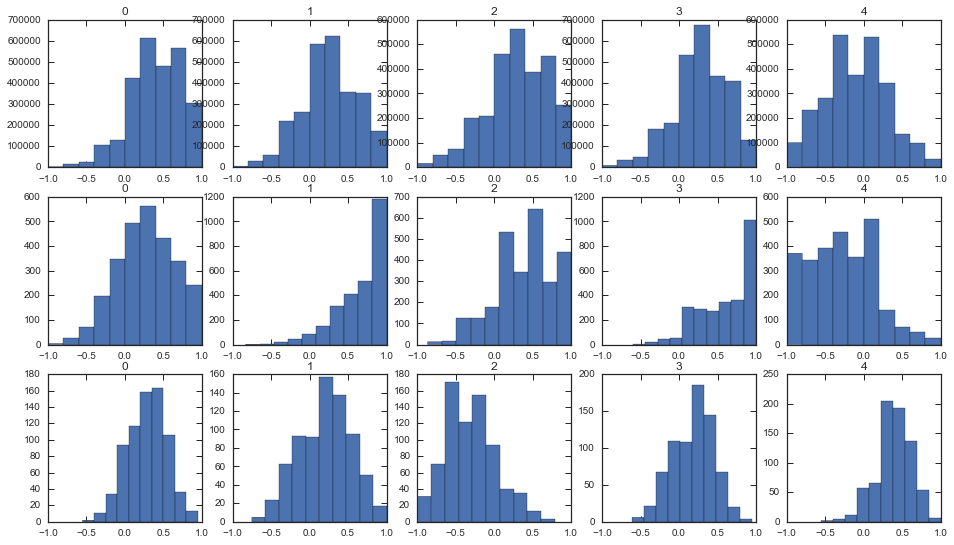

In [654]:
plt.figure(None, (16,9))
for i in range(Y0.shape[1]):
    plt.subplot(3, 5, i+1)
    plt.title(i)
    plt.hist(Y0[:, i])
    plt.xlim([-1, 1])
for i in range(Y2.shape[1]):
    plt.subplot(3, 5, i+6)
    plt.title(i)
    plt.hist(Y2[:, i])
    plt.xlim([-1, 1])
for i in range(Y3.shape[1]):
    plt.subplot(3, 5, i+11)
    plt.title(i)
    plt.hist(Y3[:, i])
    plt.xlim([-1, 1])
plt.show()